In [6]:
import nltk
from nltk.corpus import PlaintextCorpusReader
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora
from gensim import similarities
from gensim import models
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import os
import preprocess

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Preprocessing

In [7]:
corpus = preprocess.load_corpus('Data/Train/Train_Cleaned')
# len(corpus.fileids())

In [8]:
doc_cleaned = preprocess.corpus2docs(corpus)
doc_cleaned[0][:10]

['utilitarianism',
 'by',
 'john',
 'stuart',
 'mill',
 'reprint',
 'from',
 'seventh',
 'edition',
 'london']

## Bigrams and Trigrams

In [4]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(doc_cleaned, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[doc_cleaned], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [5]:
docs_bigrams = preprocess.make_bigrams(bigram_mod, doc_cleaned)
# docs_bigrams
data_bigrams_trigrams = preprocess.make_trigrams(bigram_mod, trigram_mod, docs_bigrams)
# docs_trigrams
data_bigrams_trigrams[0][0:20]

['utilitarianism',
 'john_stuart_mill',
 'reprint',
 'seventh',
 'edition',
 'london',
 'longmans',
 'green',
 'content',
 'chapter',
 'general',
 'remark',
 'chapter_ii',
 'utilitarianism',
 'chapter_iii',
 'ultimate',
 'sanction',
 'principle',
 'utility',
 'chapter_iv']

## TF-IDF Removal

In [37]:
from gensim.models import TfidfModel

id2word = corpora.Dictionary(data_bigrams_trigrams)
texts = data_bigrams_trigrams

corpus = [id2word.doc2bow(text) for text in texts]
# print(corpus[0][0:20])

tfidf = models.TfidfModel(corpus, id2word=id2word)

low_value = 0.03
words = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] #reinitialize to be safe. You can skip this.
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words+words_missing_in_tfidf
    for item in drops:
        words.append(id2word[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  
    corpus[i] = new_bow

# Topic Modeling

In [38]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of articles: %d' % len(corpus))

Number of unique tokens: 37801
Number of articles: 46


In [39]:
print(id2word)

Dictionary<37801 unique tokens: ['abandon', 'ability', 'able', 'abnegate', 'absence']...>


## LDA Model

In [40]:
# Build LDA model
lda_multicore_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

topics = lda_multicore_model.show_topics(10, 5)
for i in range(5):
    print(topics[i])

(0, '0.024*"conception" + 0.020*"government" + 0.016*"sensation" + 0.015*"image" + 0.014*"phenomenon"')
(1, '0.081*"dream" + 0.044*"woman" + 0.030*"denote" + 0.027*"zarathustra" + 0.024*"thou"')
(2, '0.037*"country" + 0.025*"price" + 0.019*"labour" + 0.018*"trade" + 0.017*"quantity"')
(3, '0.025*"child" + 0.024*"soul" + 0.024*"plato" + 0.023*"justice" + 0.019*"reply"')
(4, '0.053*"sexual" + 0.034*"dream" + 0.031*"child" + 0.027*"girl" + 0.014*"activity"')


In [41]:
# Compute Perplexity
perplex= lda_multicore_model.log_perplexity(corpus, total_docs=None)
# a measure of how good the model is. lower the better.

print('\nPerplexity for LDAMulticoreModel: ', perplex)


Perplexity for LDAMulticoreModel:  -6.130458319920368


In [42]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_multicore_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score LDAMulticoreModel: ', coherence_lda)


Coherence Score LDAMulticoreModel:  0.5367204255167299


In [43]:
# Can take a long time to run. In this case we are going to  k_max=10.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

model_list = []
coherence_values = []
model_topics = []

for num_topics in range(2, 8):
    lda_x = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=42,
                                       chunksize=100,
                                       passes=10)
    coherence_model_lda = CoherenceModel(model=lda_x, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherence_model_lda.get_coherence())
 
    model_topics.append(num_topics) 
    model_list.append(lda_x)
    print("#Topics: " + str(num_topics) + ", Score: " + str(coherence_values[-1]))

print(datetime.datetime.now())

2023-04-10 00:19:50.224298
#Topics: 2, Score: 0.27339006999474197
#Topics: 3, Score: 0.39135502412364764
#Topics: 4, Score: 0.4685407090801461
#Topics: 5, Score: 0.5367204255167299
#Topics: 6, Score: 0.48454939190312735
#Topics: 7, Score: 0.5126632324524089
2023-04-10 00:23:09.745617


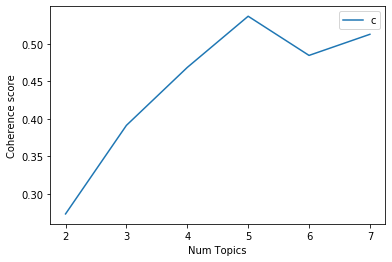

In [46]:
# Show graph

import matplotlib.pyplot as plt

limit=8; start=2; step=1;
x = range(start, limit)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [47]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2734
Num Topics = 3  has Coherence Value of 0.3914
Num Topics = 4  has Coherence Value of 0.4685
Num Topics = 5  has Coherence Value of 0.5367
Num Topics = 6  has Coherence Value of 0.4845
Num Topics = 7  has Coherence Value of 0.5127


In [48]:
pyLDAvis.enable_notebook()
visual= gensimvis.prepare(lda_multicore_model, corpus, id2word)
#Save the output to the html file
pyLDAvis.save_html(visual, "Model/base_5topic_viz.html")

C:\Users\genev\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## Hyper-Parameter Tuning and Evaluation

In [49]:
# hyper-perameter tuning (alpha and beta)
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=42,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
    perplex = lda_model.log_perplexity(corpus, total_docs=None)
    
    
    return coherence, perplex

In [50]:
# setup
import numpy as np

from gensim.models import CoherenceModel

model_list = []
coherence_values = []
perplexity_values = []
model_topics = []
alpha_result = []
beta_result = []

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

In [51]:
# Can take a few hours to run.
import datetime
import numpy as np
from gensim.models import CoherenceModel

print(datetime.datetime.now())

for a in alpha:
    for b in beta:
        for num_topics in range(2, 8):
            cv, pv = compute_coherence_values(corpus=corpus, dictionary=id2word,k=num_topics, a=a, b=b) 
            model_topics.append(num_topics)    
            coherence_values.append(cv)  
            perplexity_values.append(pv)
            alpha_result.append(a)
            beta_result.append(b)
            print("#Topics: " + str(num_topics) + ", CV Score: " + str(coherence_values[-1]) + ", PV Score: " + str(perplexity_values[-1]) + ", Alpha: " + str(alpha_result[-1]) + ", Beta: " + str(beta_result[-1]))
            
print(datetime.datetime.now())

2023-04-10 00:26:12.652711
#Topics: 2, CV Score: 0.2612667076212538, PV Score: -6.3802353007931805, Alpha: 0.01, Beta: 0.01
#Topics: 3, CV Score: 0.39135502412364764, PV Score: -6.096989463242294, Alpha: 0.01, Beta: 0.01
#Topics: 4, CV Score: 0.4685407090801461, PV Score: -5.9215791539060705, Alpha: 0.01, Beta: 0.01
#Topics: 5, CV Score: 0.5423320266088695, PV Score: -5.75923529718327, Alpha: 0.01, Beta: 0.01
#Topics: 6, CV Score: 0.4852736995780999, PV Score: -5.5903811179719956, Alpha: 0.01, Beta: 0.01
#Topics: 7, CV Score: 0.5150888314573804, PV Score: -5.491299087658399, Alpha: 0.01, Beta: 0.01
#Topics: 2, CV Score: 0.27339006999474197, PV Score: -6.6369606925152596, Alpha: 0.01, Beta: 0.31
#Topics: 3, CV Score: 0.39135502412364764, PV Score: -6.45383470398078, Alpha: 0.01, Beta: 0.31
#Topics: 4, CV Score: 0.4685407090801461, PV Score: -6.3680445440329745, Alpha: 0.01, Beta: 0.31
#Topics: 5, CV Score: 0.5367204255167299, PV Score: -6.283243278002983, Alpha: 0.01, Beta: 0.31
#Topics

#Topics: 6, CV Score: 0.43781520482921205, PV Score: -6.788495217329706, Alpha: 0.61, Beta: 0.9099999999999999
#Topics: 7, CV Score: 0.4858530186727995, PV Score: -6.717924544556863, Alpha: 0.61, Beta: 0.9099999999999999
#Topics: 2, CV Score: 0.27339006999474197, PV Score: -6.766072832998897, Alpha: 0.61, Beta: symmetric
#Topics: 3, CV Score: 0.39135502412364764, PV Score: -6.477743882706171, Alpha: 0.61, Beta: symmetric
#Topics: 4, CV Score: 0.4685407090801461, PV Score: -6.299161360298256, Alpha: 0.61, Beta: symmetric
#Topics: 5, CV Score: 0.5414268860651225, PV Score: -6.132816598748242, Alpha: 0.61, Beta: symmetric
#Topics: 6, CV Score: 0.48454939190312735, PV Score: -5.957565508112153, Alpha: 0.61, Beta: symmetric
#Topics: 7, CV Score: 0.5126632324524089, PV Score: -5.828389720683376, Alpha: 0.61, Beta: symmetric
#Topics: 2, CV Score: 0.26852354561463243, PV Score: -6.393505242304328, Alpha: 0.9099999999999999, Beta: 0.01
#Topics: 3, CV Score: 0.3913550241236477, PV Score: -6.1017

#Topics: 4, CV Score: 0.4685407090801461, PV Score: -6.36903782796309, Alpha: asymmetric, Beta: 0.31
#Topics: 5, CV Score: 0.5367204255167299, PV Score: -6.284343957604106, Alpha: asymmetric, Beta: 0.31
#Topics: 6, CV Score: 0.46727313335479764, PV Score: -6.222842146132555, Alpha: asymmetric, Beta: 0.31
#Topics: 7, CV Score: 0.4863048486297485, PV Score: -6.138470100886777, Alpha: asymmetric, Beta: 0.31
#Topics: 2, CV Score: 0.27339006999474197, PV Score: -6.830325458429164, Alpha: asymmetric, Beta: 0.61
#Topics: 3, CV Score: 0.39135502412364764, PV Score: -6.697882925414251, Alpha: asymmetric, Beta: 0.61
#Topics: 4, CV Score: 0.4348406766582404, PV Score: -6.654514942791059, Alpha: asymmetric, Beta: 0.61
#Topics: 5, CV Score: 0.5147353406772448, PV Score: -6.579748257437858, Alpha: asymmetric, Beta: 0.61
#Topics: 6, CV Score: 0.43109906774356815, PV Score: -6.539864451523388, Alpha: asymmetric, Beta: 0.61
#Topics: 7, CV Score: 0.502407956944746, PV Score: -6.4728752904130005, Alpha: 

In [52]:
hyperparameter_df = pd.DataFrame(
    {'num_topics': model_topics, 
     'coherence_score': coherence_values, 
     'perplexity_values': perplexity_values,
     'alpha': alpha_result, 
     'beta': beta_result})
hyperparameter_df

num_topics  coherence_score  perplexity_values       alpha       beta
0             2         0.261267          -6.380235        0.01       0.01
1             3         0.391355          -6.096989        0.01       0.01
2             4         0.468541          -5.921579        0.01       0.01
3             5         0.542332          -5.759235        0.01       0.01
4             6         0.485274          -5.590381        0.01       0.01
..          ...              ...                ...         ...        ...
175           3         0.391355          -6.476916  asymmetric  symmetric
176           4         0.468541          -6.297616  asymmetric  symmetric
177           5         0.536720          -6.130414  asymmetric  symmetric
178           6         0.484549          -5.954461  asymmetric  symmetric
179           7         0.512663          -5.824671  asymmetric  symmetric

[180 rows x 5 columns]

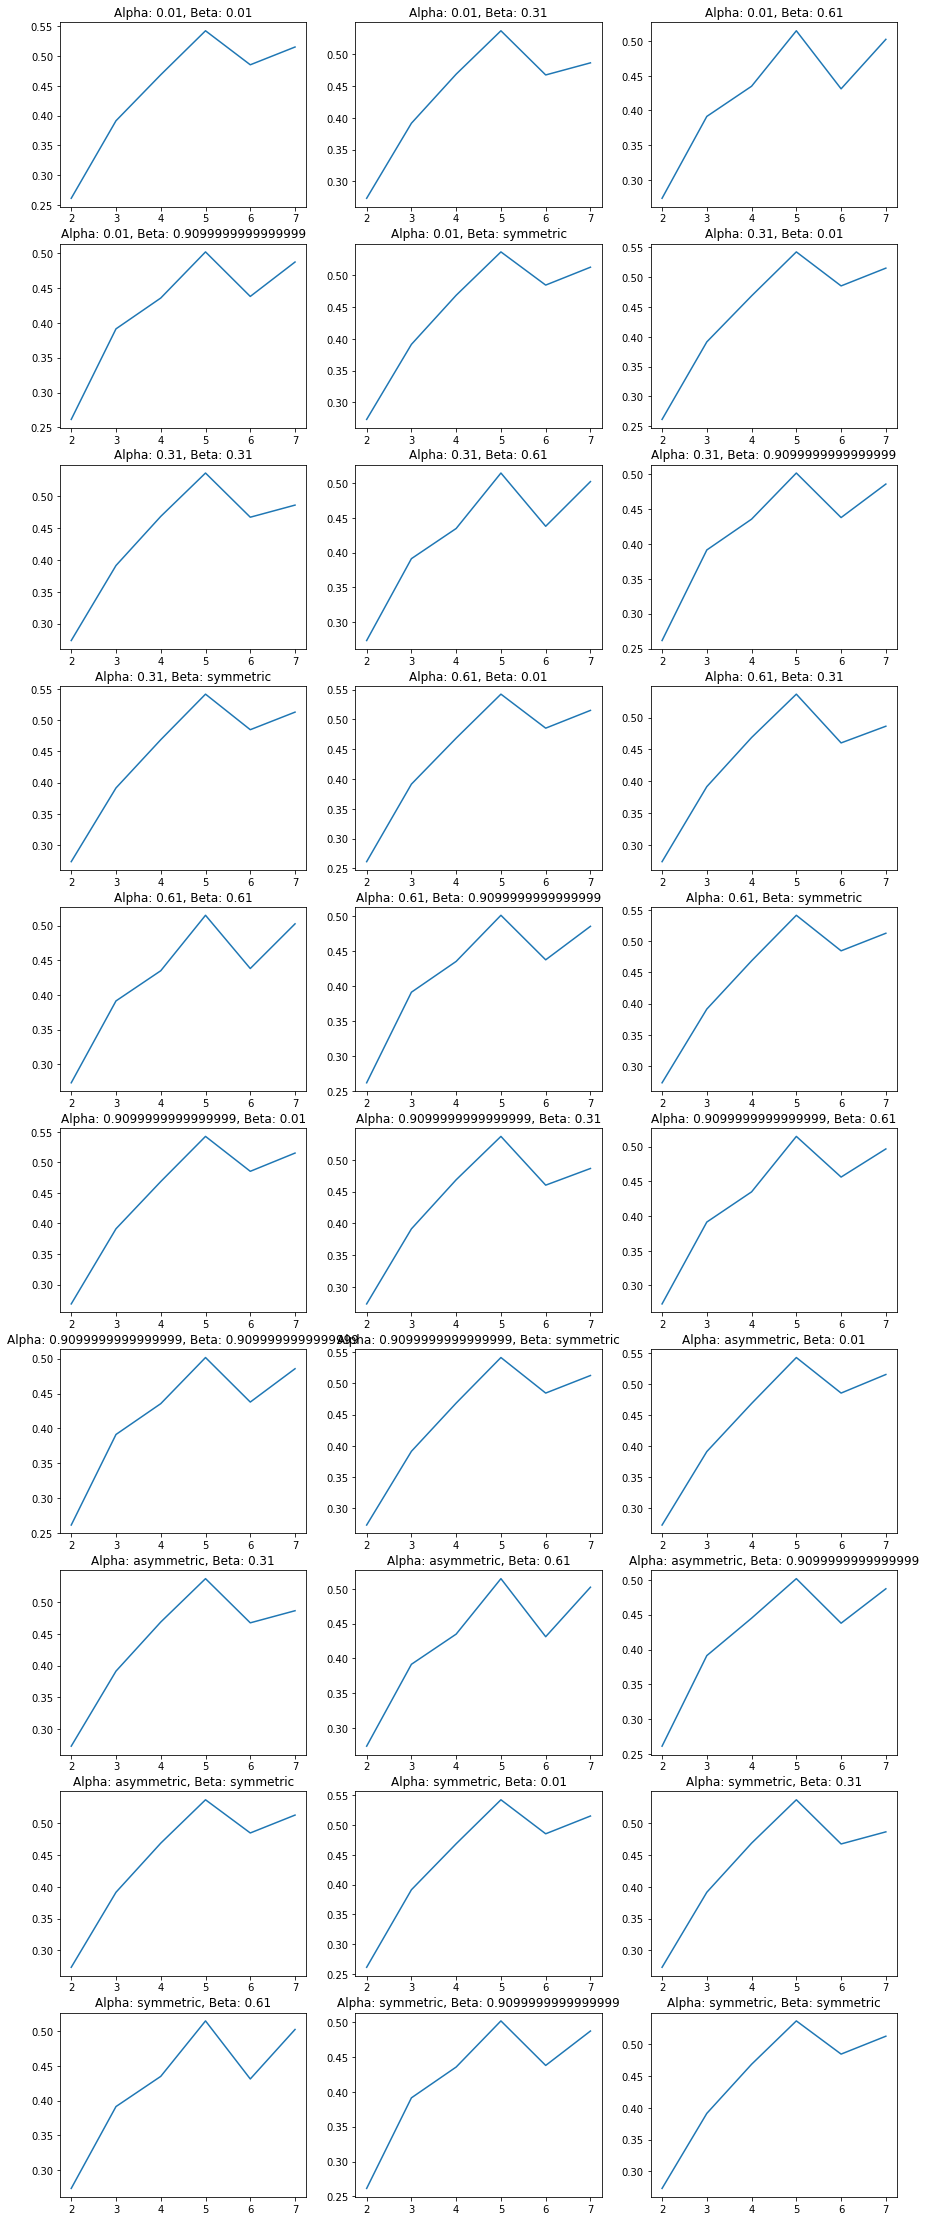

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(10,3, figsize = (15,40))
x=0
y=0

for model in hyperparameter_df.groupby(['alpha', 'beta']):
    ax[x,y].plot(model[1]['num_topics'], model[1]['coherence_score'])
    ax[x,y].title.set_text("Alpha: " + str(model[0][0]) + ", Beta: " + str(model[0][1]))
    y = y + 1
    if(y == 3):
        y = 0
        x = x + 1
# ax.set_xlabel('num_topics')
# ax.set_ylabel('coherence_score')

In [4]:
# hyperparameter_df = pd.read_csv("Model/hyperparameter_results.csv")
# hyperparameter_df.drop(hyperparameter_df.columns[0], axis=1, inplace=True)
# hyperparameter_df.head()

num_topics  coherence_score  perplexity_values alpha  beta
0           2         0.326125          -6.401565  0.01  0.01
1           3         0.419863          -6.129121  0.01  0.01
2           4         0.416545          -5.907244  0.01  0.01
3           5         0.543557          -5.657276  0.01  0.01
4           6         0.516037          -5.510954  0.01  0.01

In [68]:
hyperparameter_df.to_csv("Model/hyperparameter_results.csv")

In [62]:
topic_5 = hyperparameter_df[hyperparameter_df["num_topics"] == 5]
topic_5.sort_values(by=['coherence_score', 'perplexity_values'], ascending=[False, True], inplace=True)
topic_5.head()

C:\Users\genev\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


num_topics  coherence_score  perplexity_values       alpha  beta
93            5         0.542332          -5.764620        0.91  0.01
153           5         0.542332          -5.763510  asymmetric  0.01
63            5         0.542332          -5.762926        0.61  0.01
33            5         0.542332          -5.761108        0.31  0.01
123           5         0.542332          -5.760394   symmetric  0.01

## Final Model

After hyperparameter tuning, we chose the model with the highest coherance_score and lowest perplexity_values at 5 topics and decided to use the model with the following parameters:
- num_topics = 5
- alpha = 0.01
- beta = 0.01

which has a coherence score of 0.54 and perplexity value of -6.03.

In [63]:
k = 5
a = 0.91
b = 0.01

final_lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                             id2word=id2word,
                                             num_topics=k,
                                             random_state=42,
                                             chunksize=100,
                                             passes=10,
                                             alpha=a,
                                             eta=b)

In [61]:
pyLDAvis.enable_notebook()
visual= gensimvis.prepare(final_lda_model, corpus, id2word)
#Save the output to the html file
pyLDAvis.save_html(visual, "Model/final_5topic_viz.html")

C:\Users\genev\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [30]:
# visual

In [64]:
# Save model
lda_sav=final_lda_model

lda_sav.save("Model/finalmodel_5Topics")

In [65]:
#Code to save the document topic probabilities (theta)
vec=lda_sav[corpus]
pd.DataFrame(vec).to_csv("Model/finaldoc_topic_mixture.csv")

In [66]:
# Write code here to save top 10 words for each topic (beta)
top_words_per_topic = []
for t in range(lda_sav.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_sav.show_topic(t, topn = 10)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("Model/finaltop_words.csv")

In [67]:
id2word.save(("Model/finalmodel_Dictionary"))

### Secondary EDA

In [69]:
def format_topics_sentences(ldamodel, corpus, data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(data)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

#I choose model_list[2] where the number of topics is 6

df_topic_sents_keywords = format_topics_sentences(ldamodel=final_lda_model, corpus=corpus, data=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.8869   
1            1             2.0              0.5457   
2            2             4.0              0.9959   
3            3             2.0              0.9905   
4            4             4.0              0.9983   
5            5             3.0              0.9994   
6            6             4.0              0.9983   
7            7             3.0              0.9978   
8            8             4.0              0.8048   
9            9             0.0              0.9865   

                                            Keywords  \
0  conception, government, sensation, image, phen...   
1  country, price, labour, trade, quantity, land,...   
2  sexual, dream, child, girl, activity, young, s...   
3  country, price, labour, trade, quantity, land,...   
4  sexual, dream, child, girl, activity, young, s...   
5  child, soul, plato, justice, reply, evil, woma...   
6  sexual, dream, child, girl, activity, young, s...   
7  child, soul, plato, justice, reply, evil, woma...   
8  sexual, dream, child, girl, activity, young, s...   
9  conception, government, sensation, image, phen...   

                                                Text  
0  [utilitarianism, john_stuart_mill, reprint, se...  
1  [study, psychology, volume, erotic_symbolism, ...  
2  [youth, danger, safeguard, girl, mary, scharli...  
3  [apply, psychology, psychology, achievement, f...  
4  [nervous, mental, disease, monograph_series, t...  
5  [republic, plato, translate, benjamin, jowett,...  
6  [dream, psychology, sigmund, freud, authorize,...  
7  [talk, teacher, psychology, student, ideal, wi...  
8  [apology, plato, translate, benjamin, jowett, ...  
9  [apply, psychology, trained, memory, fourth, s...

In [70]:
# Finding most representative document - Added
# find the documents a given topic has contributed to the most

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet,
grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = [
   'Topic_Number', "Contribution_Perc", "Keywords", "Text"
]
sent_topics_sorteddf_mallet.head()

Topic_Number  Contribution_Perc  \
0           0.0             0.9997   
1           1.0             0.9996   
2           2.0             0.9999   
3           3.0             0.9994   
4           4.0             0.9995   

                                            Keywords  \
0  conception, government, sensation, image, phen...   
1  dream, woman, denote, zarathustra, thou, hath,...   
2  country, price, labour, trade, quantity, land,...   
3  child, soul, plato, justice, reply, evil, woma...   
4  sexual, dream, child, girl, activity, young, s...   

                                                Text  
0  [critique, pure, reason, immanuel, kant, trans...  
1  [thousand, dream, interpret, scientific, pract...  
2  [inquiry, nature, cause, wealth, nation, adam,...  
3  [republic, plato, translate, benjamin, jowett,...  
4  [start, project_gutenberg, democracy, educatio...

In [71]:
# Volume and distribution of Topics; how widely topic is discussed in documents

# Calc no. of docs for every topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
# Calc % of docs for every topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat(
   [topic_num_keywords, topic_counts, topic_contribution], axis=1
)
df_dominant_topics.columns = [
   'Dominant-Topic', 'Topic-Keywords', 'Num_Documents', '%_Documents'
]
df_dominant_topics.head()

Dominant-Topic                                     Topic-Keywords  \
0.0             0.0  conception, government, sensation, image, phen...   
1.0             2.0  country, price, labour, trade, quantity, land,...   
2.0             4.0  sexual, dream, child, girl, activity, young, s...   
3.0             2.0  country, price, labour, trade, quantity, land,...   
4.0             4.0  sexual, dream, child, girl, activity, young, s...   

     Num_Documents  %_Documents  
0.0           15.0       0.3261  
1.0            7.0       0.1522  
2.0            8.0       0.1739  
3.0            7.0       0.1522  
4.0            9.0       0.1957